### Pipeline do projeto de TC4


#### Importando as bibliotecas

In [16]:
import yfinance as yf
import pandas as pd
from datetime import datetime

#### Baixando os dados historicos da Microsoft Ticker 'MSFT'

In [17]:
symbol = 'MSFT'
start_date = '1980-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

In [35]:
df = yf.download(symbol, multi_level_index=False)

[*********************100%***********************]  1 of 1 completed



In [36]:
df

,Close,High,Low,Open,Volume
Date,,,,,
1986-03-13,0.059827,0.062498,0.054485,0.054485,1031788800
1986-03-14,0.061963,0.063032,0.059827,0.059827,308160000
1986-03-17,0.063032,0.063566,0.061963,0.061963,133171200
1986-03-18,0.061429,0.063566,0.060895,0.063032,67766400
1986-03-19,0.060361,0.061963,0.059827,0.061429,47894400
...,...,...,...,...,...
2025-02-03,410.920013,415.410004,408.660004,411.600006,25679100
2025-02-04,412.369995,413.920013,409.739990,412.690002,20532100
2025-02-05,413.290009,413.829987,410.399994,412.350006,16316700


#### Visualizando as informações

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

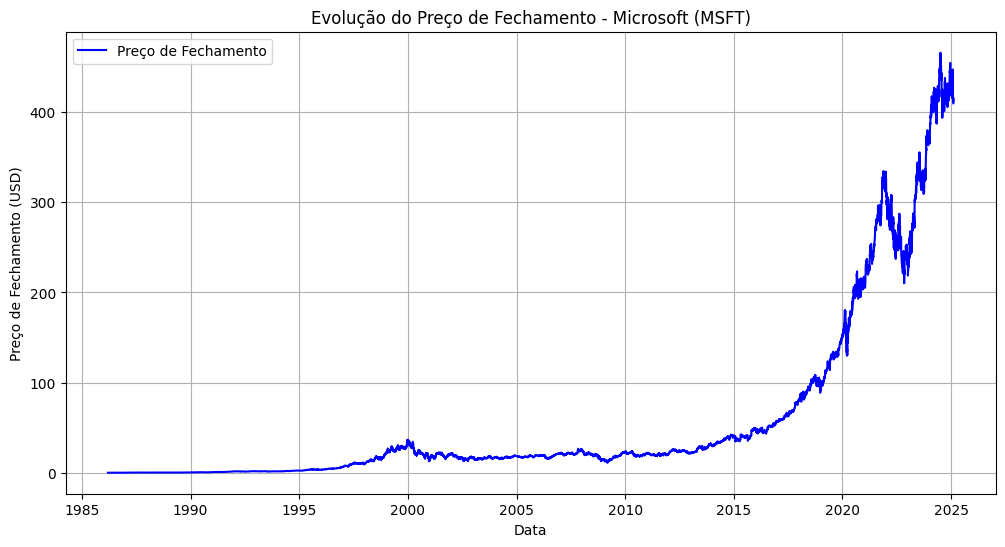

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Preço de Fechamento', color='blue')
plt.title('Evolução do Preço de Fechamento - Microsoft (MSFT)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ernan\AppData\Local\Temp\ipykernel_26416\88008106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_30'] = df['Close'].rolling(window=30).mean()  # Média móvel de 30 dias
C:\Users\ernan\AppData\Local\Temp\ipykernel_26416\88008106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_100'] = df['Close'].rolling(window=100).mean()  # Média móvel de 100 dias


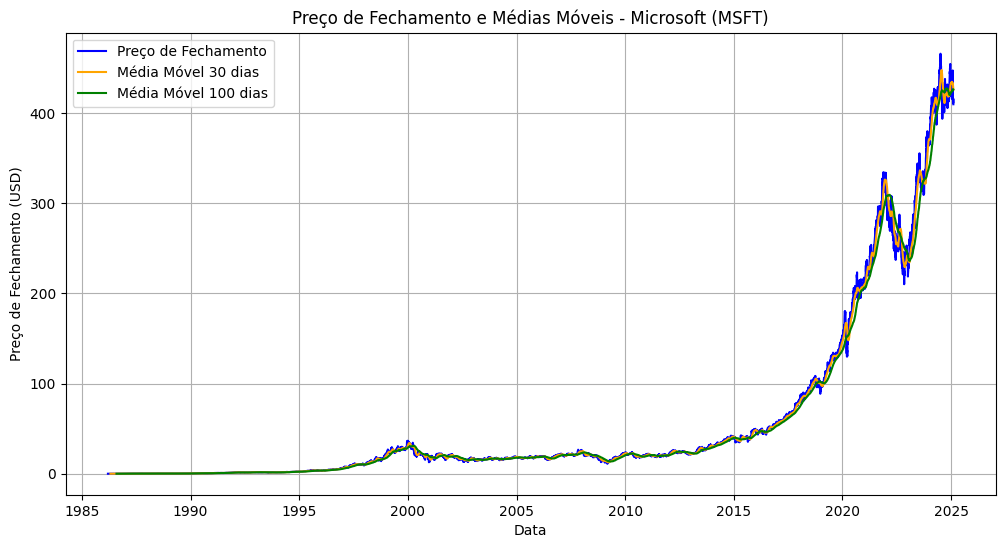

In [49]:
df['SMA_30'] = df['Close'].rolling(window=30).mean()  # Média móvel de 30 dias
df['SMA_100'] = df['Close'].rolling(window=100).mean()  # Média móvel de 100 dias

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Preço de Fechamento', color='blue')
plt.plot(df.index, df['SMA_30'], label='Média Móvel 30 dias', color='orange')
plt.plot(df.index, df['SMA_100'], label='Média Móvel 100 dias', color='green')
plt.title('Preço de Fechamento e Médias Móveis - Microsoft (MSFT)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

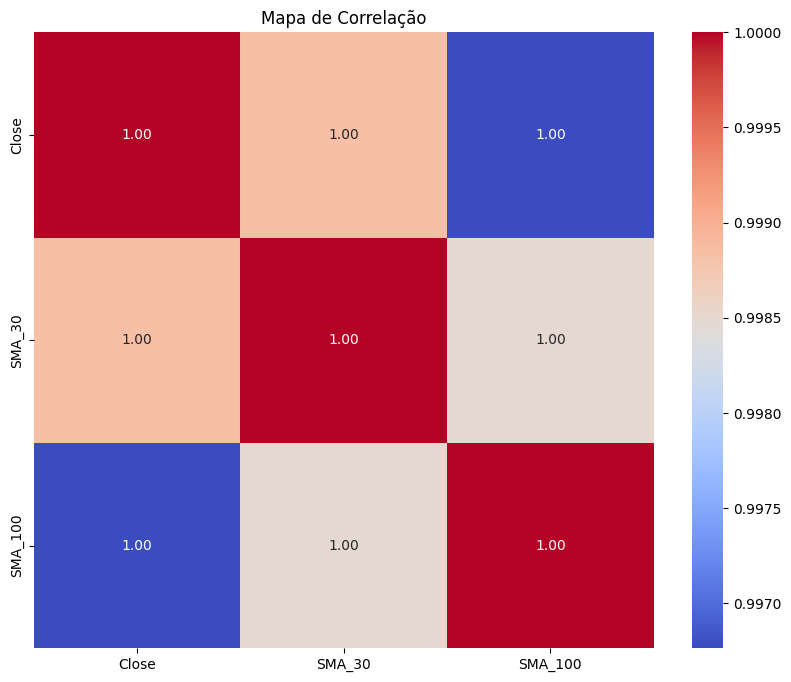

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação')
plt.show()


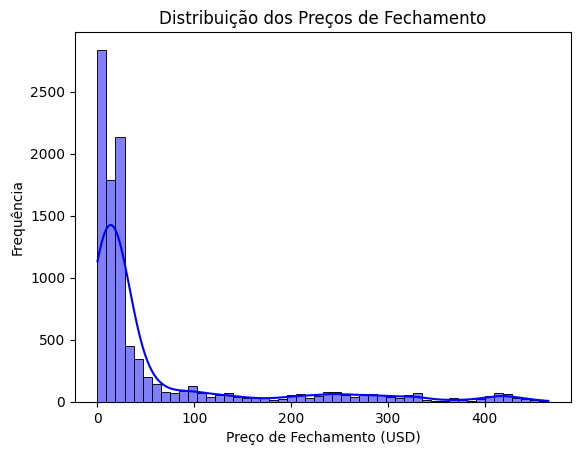

In [52]:
sns.histplot(df['Close'], bins=50, kde=True, color='blue')
plt.title('Distribuição dos Preços de Fechamento')
plt.xlabel('Preço de Fechamento (USD)')
plt.ylabel('Frequência')
plt.show()

In [58]:
import nbformat
print(nbformat.__version__)

5.10.4


In [59]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df.index, y=df["Close"], mode="lines", name="Preço de Fechamento")
)
fig.update_layout(
    title="Evolução do Preço de Fechamento - Microsoft (MSFT)",
    xaxis_title="Data",
    yaxis_title="Preço de Fechamento (USD)",
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [37]:
print(df.isnull().sum())

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [38]:
df = df[['Close']]  # Manter apenas a coluna 'Close'
df.index = pd.to_datetime(df.index)  # Converter o índice para datetime


In [39]:
df

,Close
Date,
1986-03-13,0.059827
1986-03-14,0.061963
1986-03-17,0.063032
1986-03-18,0.061429
1986-03-19,0.060361
...,...
2025-02-03,410.920013
2025-02-04,412.369995
2025-02-05,413.290009


In [41]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

In [44]:
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

In [45]:
df_scaled

,Close
Date,
1986-03-13,0.000009
1986-03-14,0.000014
1986-03-17,0.000016
1986-03-18,0.000013
1986-03-19,0.000010
...,...
2025-02-03,0.882193
2025-02-04,0.885306
2025-02-05,0.887282


In [60]:
def create_sequences(data, sequence_length=60):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append((seq, label))
    return sequences

sequence_length = 60
sequences = create_sequences(df_scaled.values, sequence_length)


In [61]:
train_size = int(len(sequences) * 0.7)
train_data = sequences[:train_size]
test_data = sequences[train_size:]


In [62]:
import numpy as np

X_train = np.array([x[0] for x in train_data])
y_train = np.array([x[1] for x in train_data])

X_test = np.array([x[0] for x in test_data])
y_test = np.array([x[1] for x in test_data])

# Reshape para o formato (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
